In [2]:
# Import libraries/packages
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [4]:
# Load Data
ROOT = Path.cwd().parent
model_output = pd.read_csv(ROOT / 'data/processed/model_output.csv')
fuel_data_raw = pd.read_csv(ROOT / 'data/raw/fuel_data_raw_anon.csv')
truck_config = pd.read_csv(ROOT / 'data/processed/truck_config_julia.csv')
station_demand = pd.read_csv(ROOT / 'data/processed/station_demand_julia.csv')

#### Model Performance Summary

In [ ]:
# Calculate total performance metrics
total_volume = model_output["Liters_Delivered"].sum()
total_trips = model_output["Trips"].sum()
total_distance = model_output["Distance_Travelled_km"].sum()
max_trailer_distance = model_output.groupby("Trailer")["Distance_Travelled_km"].sum().max()
unique_trailers_used = model_output["Trailer"].nunique()
avg_distance_per_trip = total_distance / total_trips if total_trips > 0 else 0

# Create updated summary table
summary_df = pd.DataFrame({
    "Metric": [
        "Total Volume Delivered (L)",
        "Total Number of Trips",
        "Total Distance Travelled (km)",
        "Maximum Distance by Any One Trailer (km)",
        "Number of Unique Trailers Used",
        "Average Distance per Trip (km)"
    ],
    "Value": [
        round(total_volume, 2),
        round(total_trips, 2),
        round(total_distance, 2),
        round(max_trailer_distance, 2),
        unique_trailers_used,
        round(avg_distance_per_trip, 2)
    ]
})

summary_df.head(10)

,Metric,Value
0,Total Volume Delivered (L),15800165.45
1,Total Number of Trips,579.00
2,Total Distance Travelled (km),41397.99
3,Maximum Distance by Any One Trailer (km),1858.99
4,Number of Unique Trailers Used,28.00
5,Average Distance per Trip (km),71.50


#### Sample of Full-Capacity Trips

In [7]:
# Merge truck capacities into the model output
merged_df = model_output.merge(truck_config[["Trailer", "Truck_Tank_Capacity_Liters"]], on="Trailer", how="left")

# Filter rows where Trips are whole number floats (e.g., 2.0, 5.0) but delivered volume is an exact multiple of tank capacity
merged_df["Expected_Liters"] = merged_df["Trips"] * merged_df["Truck_Tank_Capacity_Liters"]
merged_df["Exact_Match"] = abs(merged_df["Expected_Liters"] - merged_df["Liters_Delivered"]) < 1e-2

# Get a sample of exact matches for demonstration
trip_match_examples = merged_df[merged_df["Exact_Match"]].head(10)[[
    "Trailer", "Destination_ID", "Product", "Trips", "Truck_Tank_Capacity_Liters", "Liters_Delivered", "Distance_Travelled_km"
]]

trip_match_examples.head(5)

,Trailer,Destination_ID,Product,Trips,Truck_Tank_Capacity_Liters,Liters_Delivered,Distance_Travelled_km
16,Trailer_36,Station_11,Product_3,5.0,43187.00,215935.00,441.470
20,Trailer_33,Station_12,Product_3,1.0,42000.54,42000.54,17.404
22,Trailer_37,Station_12,Product_3,10.0,42000.00,420000.00,174.040
83,Trailer_36,Station_22,Product_1,1.0,43187.00,43187.00,133.448
84,Trailer_37,Station_22,Product_1,6.0,42000.00,252000.00,800.688


#### Comparison of Total Distance Travelled - Actual vs Model

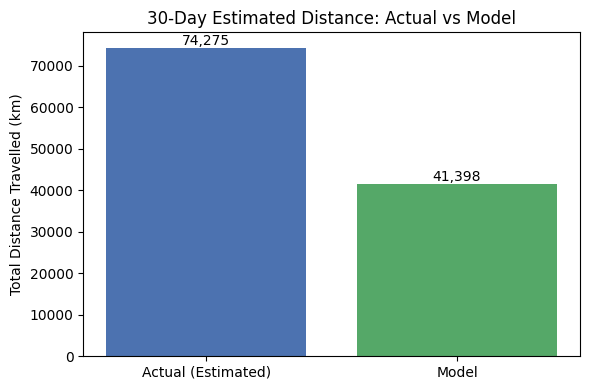

In [32]:
# Filter actual data to match model scope (i.e., deliveries from Source_2)
filtered_actual = fuel_data_raw[fuel_data_raw["Origin_ID"] == "Source_2"].copy()

# Ensure Delivery_Date is datetime
filtered_actual["Delivery_Date"] = pd.to_datetime(filtered_actual["Delivery_Date"])

# Calculate daily round-trip distance
filtered_actual["RoundTrip_Distance"] = filtered_actual["Distance_km"] * 2
daily_distance = filtered_actual.groupby("Delivery_Date")["RoundTrip_Distance"].sum()

# Compute average daily distance and scale to 30 days
avg_daily_distance = daily_distance.mean()
actual_estimated_30day = avg_daily_distance * 30

# Model total distance
model_total_distance = model_output["Distance_Travelled_km"].sum()

# Prepare comparison DataFrame
distance_comparison = pd.DataFrame({
    "Source": ["Actual (Estimated)", "Model"],
    "Total Distance (km)": [actual_estimated_30day, model_total_distance]
})

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(
    distance_comparison["Source"],
    distance_comparison["Total Distance (km)"],
    color=["#4c72b0", "#55a868"]
)

plt.ylabel("Total Distance Travelled (km)")
plt.title("30-Day Estimated Distance: Actual vs Model")

# Annotate with values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:,.0f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
actual_total_km = 74275
model_total_km = 41398

# Fuel efficiency values (litres per 100 km)
efficiencies = [30, 40]

# Fuel usage (litres)
model_fuel_usage_litres = [model_total_km * eff / 100 for eff in efficiencies]
actual_fuel_usage_litres = [actual_total_km * eff / 100 for eff in efficiencies]

# Convert litres to gallons
litres_to_gallons = lambda litres: litres / 3.78541
model_fuel_usage_gallons = [litres_to_gallons(val) for val in model_fuel_usage_litres]
actual_fuel_usage_gallons = [litres_to_gallons(val) for val in actual_fuel_usage_litres]

# Diesel price in USD/gallon
price_per_gallon = 3.739

# Fuel cost (USD)
model_cost_usd = [gallons * price_per_gallon for gallons in model_fuel_usage_gallons]
actual_cost_usd = [gallons * price_per_gallon for gallons in actual_fuel_usage_gallons]
cost_savings_usd = [actual - model for actual, model in zip(actual_cost_usd, model_cost_usd)]

# Summary
summary_df = pd.DataFrame({
    "Fuel Efficiency (L/100km)": efficiencies,
    "Model Fuel Used (L)": model_fuel_usage_litres,
    "Actual Fuel Used (L)": actual_fuel_usage_litres,
    "Model Fuel Cost (USD)": model_cost_usd,
    "Actual Fuel Cost (USD)": actual_cost_usd,
    "Estimated Fuel Savings (USD)": cost_savings_usd
})

# Format
formatted_summary_df = summary_df.copy()
formatted_summary_df["Model Fuel Used (L)"] = formatted_summary_df["Model Fuel Used (L)"].map("{:,.0f}".format)
formatted_summary_df["Actual Fuel Used (L)"] = formatted_summary_df["Actual Fuel Used (L)"].map("{:,.0f}".format)
formatted_summary_df["Model Fuel Cost (USD)"] = formatted_summary_df["Model Fuel Cost (USD)"].map("${:,.2f}".format)
formatted_summary_df["Actual Fuel Cost (USD)"] = formatted_summary_df["Actual Fuel Cost (USD)"].map("${:,.2f}".format)
formatted_summary_df["Estimated Fuel Savings (USD)"] = formatted_summary_df["Estimated Fuel Savings (USD)"].map("${:,.2f}".format)

formatted_summary_df.head(10)

,Fuel Efficiency (L/100km),Model Fuel Used (L),Actual Fuel Used (L),Model Fuel Cost (USD),Actual Fuel Cost (USD),Estimated Fuel Savings (USD)
0,30,"12,419","22,282","$12,267.14","$22,009.31","$9,742.18"
1,40,"16,559","29,710","$16,356.18","$29,345.75","$12,989.57"


#### Monthly Distance Travelled per Trailer - Model vs Historical Average

Included trailers: 21 of 28 used in model


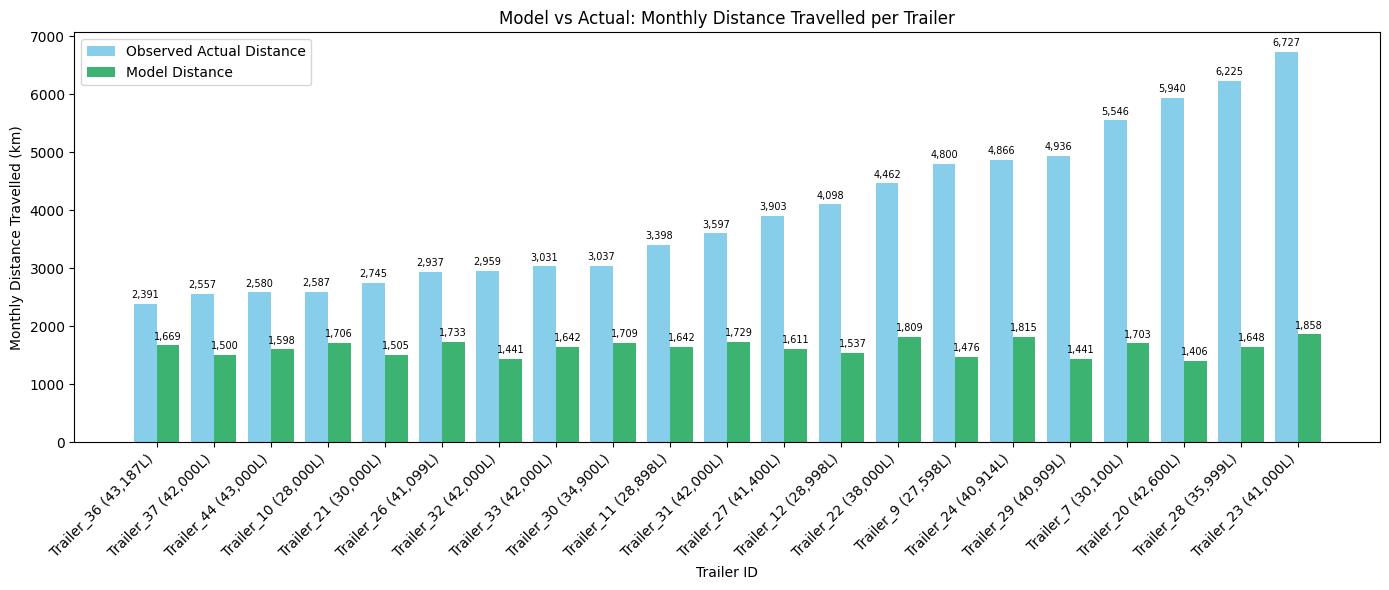

In [10]:

fuel_data_raw['Delivery_Date'] = pd.to_datetime(fuel_data_raw['Delivery_Date'])
fuel_data_raw['YearMonth'] = fuel_data_raw['Delivery_Date'].dt.to_period('M')

# Filter for only Source_2 origin trips
fuel_data_raw = fuel_data_raw[fuel_data_raw['Origin_ID'] == 'Source_2']

#  Calculate actual monthly distance per trailer
fuel_data_raw['Monthly_RoundTrip_Distance'] = fuel_data_raw['Distance_km'] * 2
monthly_dist = (
    fuel_data_raw
    .groupby(['Trailer', 'YearMonth'])['Monthly_RoundTrip_Distance']
    .sum()
    .reset_index()
)

avg_dist_per_trailer = (
    monthly_dist
    .groupby('Trailer')['Monthly_RoundTrip_Distance']
    .mean()
    .reset_index()
    .rename(columns={'Monthly_RoundTrip_Distance': 'Avg_Actual_Distance_km'})
)

# Get modelled monthly distance per trailer
model_dist = (
    model_output
    .groupby('Trailer')['Distance_Travelled_km']
    .sum()
    .reset_index()
    .rename(columns={'Distance_Travelled_km': 'Model_Distance_km'})
)

# Merge with trailer config to get availability and distance limit
trailer_comparison = pd.merge(avg_dist_per_trailer, model_dist, on='Trailer', how='inner')
trailer_comparison = pd.merge(
    trailer_comparison,
    truck_config[['Trailer', 'Truck_Tank_Capacity_Liters']],
    on='Trailer',
    how='left'
)

# Sort by actual distance for better visualization
comparison_df_sorted = trailer_comparison.sort_values("Avg_Actual_Distance_km")
print(f"Included trailers: {trailer_comparison.shape[0]} of {model_output['Trailer'].nunique()} used in model")

# Plotting the comparison
plt.figure(figsize=(14, 6))
bar_width = 0.4
index = range(len(comparison_df_sorted))

# Bar plots
plt.bar([i - bar_width/2 for i in index], comparison_df_sorted['Avg_Actual_Distance_km'], 
        width=bar_width, label='Observed Actual Distance', color='skyblue')
plt.bar([i + bar_width/2 for i in index], comparison_df_sorted['Model_Distance_km'], 
        width=bar_width, label='Model Distance', color='mediumseagreen')

for i, row in enumerate(comparison_df_sorted.itertuples()):
    plt.text(i - bar_width/2, row.Avg_Actual_Distance_km + 100, f"{int(row.Avg_Actual_Distance_km):,}", ha='center', fontsize=7)
    plt.text(i + bar_width/2, row.Model_Distance_km + 100, f"{int(row.Model_Distance_km):,}", ha='center', fontsize=7)

# Axis labels and title
plt.xlabel("Trailer ID")
plt.ylabel("Monthly Distance Travelled (km)")
plt.title("Model vs Actual: Monthly Distance Travelled per Trailer")
plt.xticks(
    index, 
    comparison_df_sorted.apply(lambda row: f"{row['Trailer']} ({int(row['Truck_Tank_Capacity_Liters']):,}L)", axis=1),
    rotation=45, ha='right'
)
plt.legend()
plt.tight_layout()

#### Monthly Trips Assigned per Trailer - Model vs Historical Average

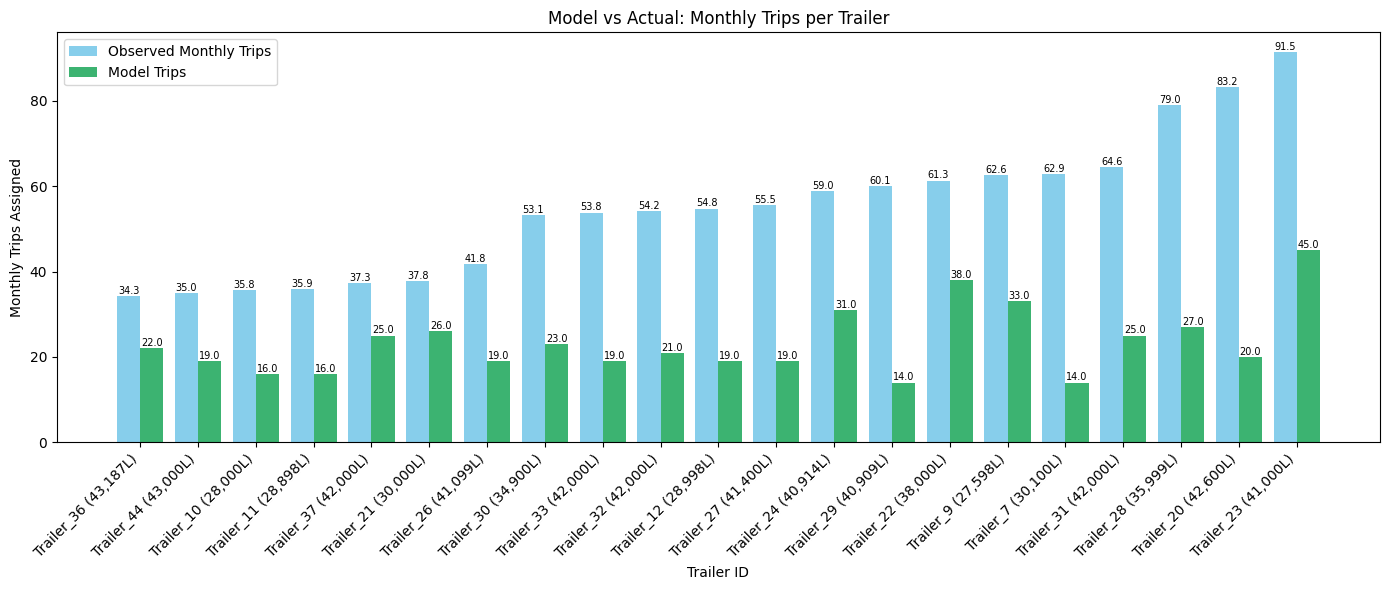

In [11]:
fuel_data_raw["Delivery_Date"] = pd.to_datetime(fuel_data_raw["Delivery_Date"])
fuel_data_raw["YearMonth"] = fuel_data_raw["Delivery_Date"].dt.to_period("M")

# Filter for Source_2 only
filtered_actual = fuel_data_raw[fuel_data_raw["Origin_ID"] == "Source_2"].copy()

# Calculate actual monthly average trips per trailer - Each row is a delivery, so we count total deliveries per trailer per month
monthly_trips_actual = (
    filtered_actual.groupby(["Trailer", "YearMonth"]).size().reset_index(name="Trips")
)

avg_trips_per_trailer = (
    monthly_trips_actual.groupby("Trailer")["Trips"].mean().reset_index()
    .rename(columns={"Trips": "Avg_Actual_Trips"})
)

# Get modelled total trips per trailer
model_trips = (
    model_output.groupby("Trailer")["Trips"].sum().reset_index()
    .rename(columns={"Trips": "Model_Trips"})
)

# Merge on common trailers (21 trailers used in both actual and model)
trips_comparison = pd.merge(avg_trips_per_trailer, model_trips, on="Trailer", how="inner")

# Merge truck capacity for labels
trips_comparison = trips_comparison.merge(
    truck_config[["Trailer", "Truck_Tank_Capacity_Liters"]],
    on="Trailer", how="left"
)

# Sort
trips_sorted = trips_comparison.sort_values("Avg_Actual_Trips")

# Plot
plt.figure(figsize=(14, 6))
bar_width = 0.4
index = range(len(trips_sorted))

# Plot bars
plt.bar([i - bar_width/2 for i in index], trips_sorted["Avg_Actual_Trips"],
        width=bar_width, label="Observed Monthly Trips", color="skyblue")
plt.bar([i + bar_width/2 for i in index], trips_sorted["Model_Trips"],
        width=bar_width, label="Model Trips", color="mediumseagreen")

# Add value labels
for i, row in enumerate(trips_sorted.itertuples()):
    plt.text(i - bar_width/2, row.Avg_Actual_Trips + 0.5, f"{row.Avg_Actual_Trips:.1f}", ha='center', fontsize=7)
    plt.text(i + bar_width/2, row.Model_Trips + 0.5, f"{row.Model_Trips:.1f}", ha='center', fontsize=7)

plt.xticks(
    index,
    trips_sorted.apply(lambda row: f"{row['Trailer']} ({int(row['Truck_Tank_Capacity_Liters']):,}L)", axis=1),
    rotation=45, ha='right'
)
plt.ylabel("Monthly Trips Assigned")
plt.xlabel("Trailer ID")
plt.title("Model vs Actual: Monthly Trips per Trailer")
plt.legend()
plt.tight_layout()
plt.show()

#### Monthly Distance Travelled per Station - Model vs Historical Average

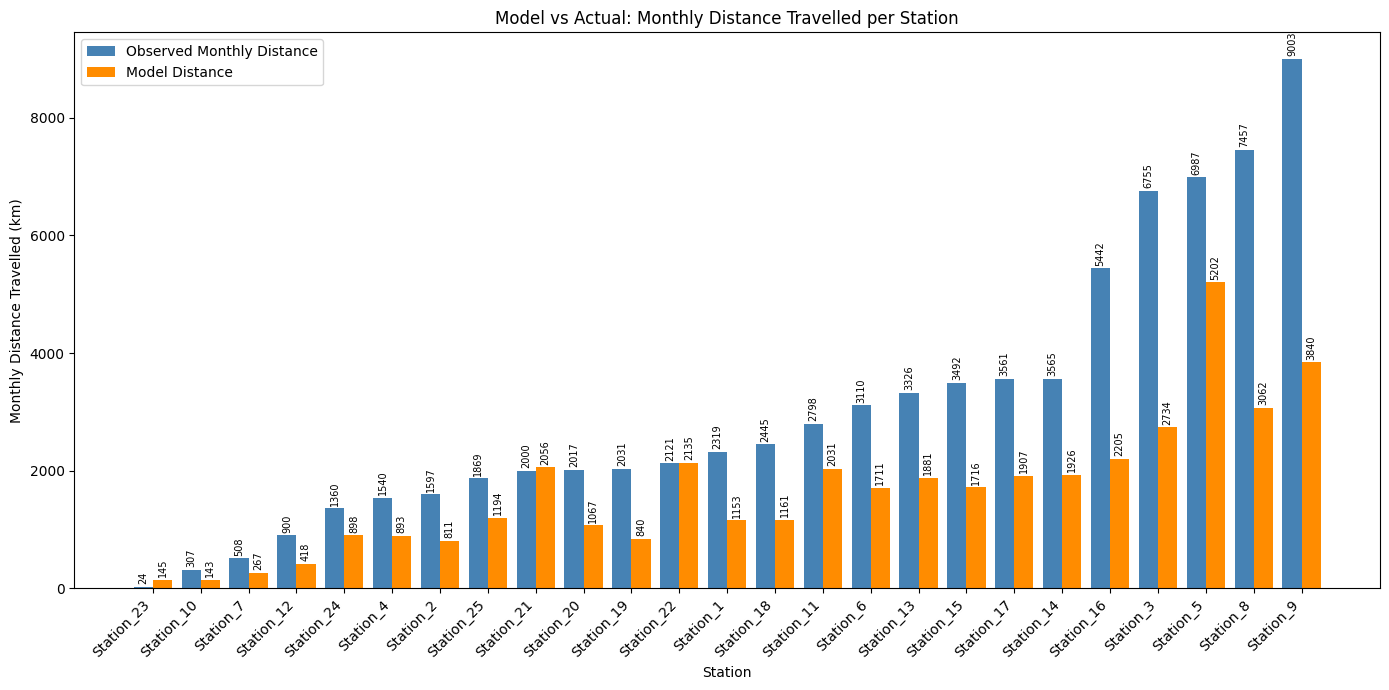

In [ ]:
# Preprocess and filter for Source_2
fuel_data_raw["Delivery_Date"] = pd.to_datetime(fuel_data_raw["Delivery_Date"])
fuel_data_raw["YearMonth"] = fuel_data_raw["Delivery_Date"].dt.to_period("M")
fuel_data_filtered = fuel_data_raw[fuel_data_raw["Origin_ID"] == "Source_2"].copy()

# Calculate round-trip distance
fuel_data_filtered["RoundTrip_Distance_km"] = fuel_data_filtered["Distance_km"] * 2

# Aggregate actual monthly distance per station
station_monthly_actual = (
    fuel_data_filtered.groupby(["Destination_ID", "YearMonth"])["RoundTrip_Distance_km"]
    .sum()
    .reset_index()
)

# Compute average actual monthly distance per station
avg_actual_station = (
    station_monthly_actual.groupby("Destination_ID")["RoundTrip_Distance_km"]
    .mean()
    .reset_index()
    .rename(columns={"RoundTrip_Distance_km": "Avg_Actual_Distance_km"})
)

# Aggregate total model distance per station
station_model = (
    model_output.groupby("Destination_ID")["Distance_Travelled_km"]
    .sum()
    .reset_index()
    .rename(columns={"Distance_Travelled_km": "Model_Distance_km"})
)

# Merge actual and model results
station_comparison = pd.merge(avg_actual_station, station_model, on="Destination_ID", how="inner")

# Sort by actual for better visual layout
comparison_df_sorted = station_comparison.sort_values("Avg_Actual_Distance_km")

# Plot with value labels
plt.figure(figsize=(14, 7))
bar_width = 0.4
index = range(len(comparison_df_sorted))

# Bars for actual
plt.bar(
    [i - bar_width/2 for i in index],
    comparison_df_sorted["Avg_Actual_Distance_km"],
    width=bar_width, label="Observed Monthly Distance", color="steelblue"
)

# Bars for model
plt.bar(
    [i + bar_width/2 for i in index],
    comparison_df_sorted["Model_Distance_km"],
    width=bar_width, label="Model Distance", color="darkorange"
)

# Add value labels to bars
for i, row in enumerate(comparison_df_sorted.itertuples()):
    plt.text(i - bar_width/2, row.Avg_Actual_Distance_km + 80, f"{row.Avg_Actual_Distance_km:.0f}", 
             ha='center', fontsize=7, rotation=90)
    plt.text(i + bar_width/2, row.Model_Distance_km + 80, f"{row.Model_Distance_km:.0f}", 
             ha='center', fontsize=7, rotation=90)

# Labels and formatting
plt.xlabel("Station")
plt.ylabel("Monthly Distance Travelled (km)")
plt.title("Model vs Actual: Monthly Distance Travelled per Station")
plt.xticks(index, comparison_df_sorted["Destination_ID"], rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

#### Monthly Trips per Station - Model vs Historical Average

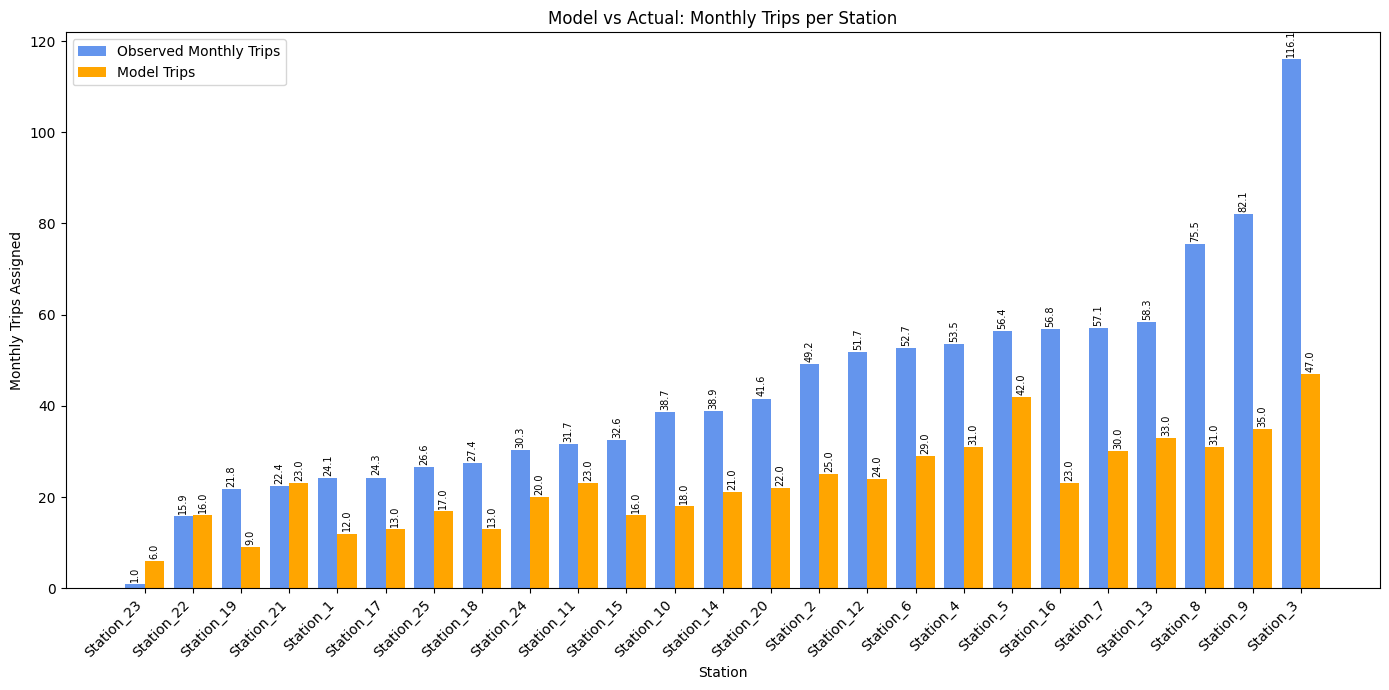

In [13]:
# Aggregate actual trips per station per month
station_monthly_trips_actual = (
    fuel_data_filtered.groupby(["Destination_ID", "YearMonth"]).size().reset_index(name="Trips")
)

# Compute average actual monthly trips per station
avg_actual_trips_station = (
    station_monthly_trips_actual.groupby("Destination_ID")["Trips"]
    .mean()
    .reset_index()
    .rename(columns={"Trips": "Avg_Actual_Trips"})
)

# Aggregate model trips per station
model_trips_station = (
    model_output.groupby("Destination_ID")["Trips"]
    .sum()
    .reset_index()
    .rename(columns={"Trips": "Model_Trips"})
)

# Merge both datasets
station_trip_comparison = pd.merge(avg_actual_trips_station, model_trips_station, on="Destination_ID", how="inner")

# Sort
station_trip_sorted = station_trip_comparison.sort_values("Avg_Actual_Trips")

# Plot
plt.figure(figsize=(14, 7))
bar_width = 0.4
index = range(len(station_trip_sorted))

# Plot bars
plt.bar([i - bar_width/2 for i in index], station_trip_sorted["Avg_Actual_Trips"],
        width=bar_width, label="Observed Monthly Trips", color="cornflowerblue")
plt.bar([i + bar_width/2 for i in index], station_trip_sorted["Model_Trips"],
        width=bar_width, label="Model Trips", color="orange")

# Add value labels
for i, row in enumerate(station_trip_sorted.itertuples()):
    plt.text(i - bar_width/2, row.Avg_Actual_Trips + 0.9, f"{row.Avg_Actual_Trips:.1f}", ha='center', fontsize=7, rotation=90)
    plt.text(i + bar_width/2, row.Model_Trips + 0.9, f"{row.Model_Trips:.1f}", ha='center', fontsize=7, rotation=90)

plt.xticks(
    index,
    station_trip_sorted["Destination_ID"],
    rotation=45, ha="right"
)
plt.ylabel("Monthly Trips Assigned")
plt.xlabel("Station")
plt.title("Model vs Actual: Monthly Trips per Station")
plt.legend()
plt.tight_layout()


#### Trailer Constraints Summary

In [14]:
# Aggregate actuals per trailer
trailer_totals = model_output.groupby("Trailer")[["Trips", "Distance_Travelled_km"]].sum().reset_index()

# Get unique trailer-level constraints (one row per trailer)
trailer_limits = truck_config[["Trailer", "Truck_Type", "Max_Trips_Per_Day", "Distance_Limit_Per_Day"]].copy()
trailer_limits["Max_Trips_Total"] = trailer_limits["Max_Trips_Per_Day"] * 30
trailer_limits["Max_Distance_Total"] = trailer_limits["Distance_Limit_Per_Day"] * 30

# Merge actuals with limits
model_summary_fixed = pd.merge(trailer_totals, trailer_limits, on="Trailer", how="left")

# Check for violations
model_summary_fixed["Trips_Exceeded"] = model_summary_fixed["Trips"] > model_summary_fixed["Max_Trips_Total"]
model_summary_fixed["Distance_Exceeded"] = model_summary_fixed["Distance_Travelled_km"] > model_summary_fixed["Max_Distance_Total"]

# Group by Truck_Type for summary tables
trip_summary_table = (
    model_summary_fixed.groupby(["Truck_Type", "Max_Trips_Total"])
    .agg(
        Number_of_Trailers=("Trailer", "count"),
        Min_Trips=("Trips", "min"),
        Max_Trips=("Trips", "max"),
        Trips_Violated=("Trips_Exceeded", "sum")
    )
    .reset_index()
    .rename(columns={
        "Truck_Type": "Trailer Type",
        "Max_Trips_Total": "30-Day Max Trips",
        "Number_of_Trailers": "Number of Trailers",
        "Min_Trips": "Min Trips",
        "Max_Trips": "Max Trips",
        "Trips_Violated": "Trips Violated"
    })
)

distance_summary_table = (
    model_summary_fixed.groupby(["Truck_Type", "Max_Distance_Total"])
    .agg(
        Number_of_Trailers=("Trailer", "count"),
        Min_Distance=("Distance_Travelled_km", "min"),
        Max_Distance=("Distance_Travelled_km", "max"),
        Distance_Violated=("Distance_Exceeded", "sum")
    )
    .reset_index()
    .rename(columns={
        "Truck_Type": "Trailer Type",
        "Max_Distance_Total": "30-Day Max Distance",
        "Number_of_Trailers": "Number of Trailers",
        "Min_Distance": "Min Distance (km)",
        "Max_Distance": "Max Distance (km)",
        "Distance_Violated": "Distance Violated"
    })
)


#### Trailer Trip Constraint Summary

In [15]:
trip_summary_table.head()

,Trailer Type,30-Day Max Trips,Number of Trailers,Min Trips,Max Trips,Trips Violated
0,Large,180,17,14.0,45.0,0
1,Medium,150,7,15.0,33.0,0
2,Small,120,4,1.0,12.0,0


#### Trailer Distance Constraint Summary

In [16]:
distance_summary_table.head()

,Trailer Type,30-Day Max Distance,Number of Trailers,Min Distance (km),Max Distance (km),Distance Violated
0,Large,10500,17,1406.274,1858.986,0
1,Medium,7500,7,1428.866,1752.238,0
2,Small,6000,4,123.858,1114.722,0


#### Delivery Frequency by Product - Model vs Historical Average

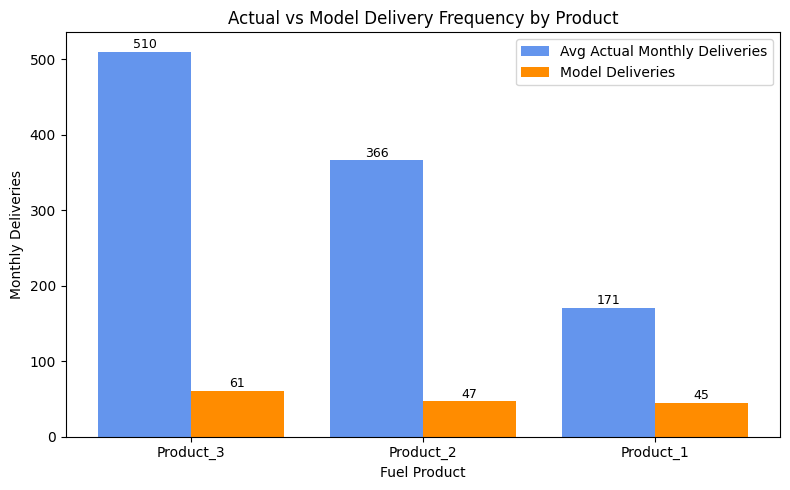

In [ ]:
# Preprocess and filter for Source_2
fuel_data_raw["Delivery_Date"] = pd.to_datetime(fuel_data_raw["Delivery_Date"])
fuel_data_raw["YearMonth"] = fuel_data_raw["Delivery_Date"].dt.to_period("M")
fuel_data_filtered = fuel_data_raw[fuel_data_raw["Origin_ID"] == "Source_2"].copy()

# Calculate average monthly deliveries per product (actual)
monthly_actual = (
    fuel_data_raw
    .groupby(["Product", "YearMonth"])
    .size()
    .reset_index(name="Monthly_Deliveries")
)

avg_actual_freq = (
    monthly_actual
    .groupby("Product")["Monthly_Deliveries"]
    .mean()
    .reset_index(name="Avg_Actual_Monthly_Deliveries")
)

# Model delivery frequency per product
model_freq = model_output.groupby("Product").size().reset_index(name="Model_Deliveries")

# Merge and sort
delivery_comparison = pd.merge(avg_actual_freq, model_freq, on="Product", how="inner")
delivery_comparison = delivery_comparison.sort_values("Avg_Actual_Monthly_Deliveries", ascending=False)

# Plot with value labels and no grid
plt.figure(figsize=(8, 5))
bar_width = 0.4
x = range(len(delivery_comparison))

# Bars
bars1 = plt.bar([i - bar_width/2 for i in x], delivery_comparison["Avg_Actual_Monthly_Deliveries"],
                width=bar_width, label="Avg Actual Monthly Deliveries", color="cornflowerblue")
bars2 = plt.bar([i + bar_width/2 for i in x], delivery_comparison["Model_Deliveries"],
                width=bar_width, label="Model Deliveries", color="darkorange")

# Add value labels
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f"{yval:.0f}", ha='center', va='bottom', fontsize=9)

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f"{yval:.0f}", ha='center', va='bottom', fontsize=9)

# Axis and title
plt.xticks(x, delivery_comparison["Product"])
plt.xlabel("Fuel Product")
plt.ylabel("Monthly Deliveries")
plt.title("Actual vs Model Delivery Frequency by Product")
plt.legend()
plt.tight_layout()
plt.show()

#### Load Utilization per Trailer - Model vs Historical Average

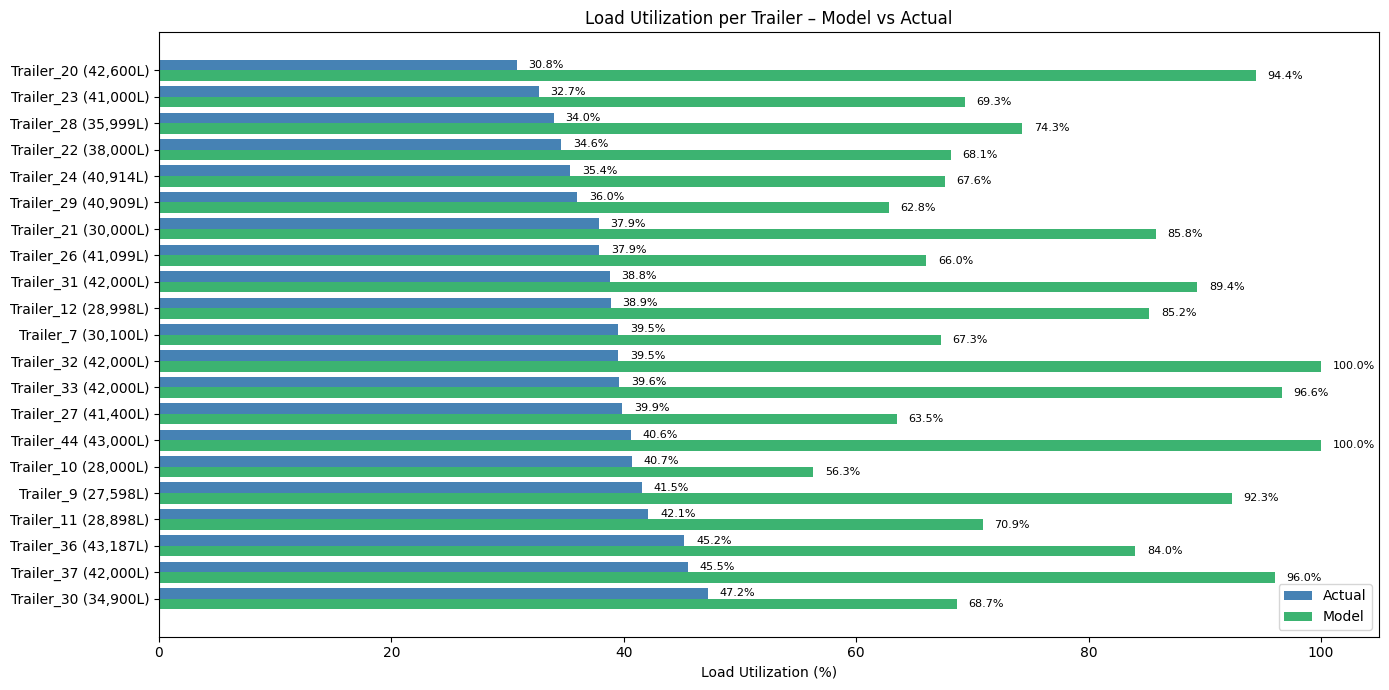

In [22]:
# Prepare model utilization
model_with_capacity = pd.merge(
    model_output,
    truck_config[["Trailer", "Truck_Tank_Capacity_Liters"]],
    on="Trailer",
    how="left"
)

load_utilization_df = (
    model_with_capacity
    .groupby("Trailer")
    .agg(
        Total_Delivered_Liters=("Liters_Delivered", "sum"),
        Total_Trips=("Trips", "sum"),
        Capacity_Per_Trip=("Truck_Tank_Capacity_Liters", "first")
    )
    .reset_index()
)

load_utilization_df["Total_Capacity_Liters"] = load_utilization_df["Total_Trips"] * load_utilization_df["Capacity_Per_Trip"]
load_utilization_df["Load_Utilization_Percent"] = (load_utilization_df["Total_Delivered_Liters"] / load_utilization_df["Total_Capacity_Liters"]) * 100

# Prepare actual utilization
fuel_data_raw["Delivery_Date"] = pd.to_datetime(fuel_data_raw["Delivery_Date"])
fuel_data_raw["YearMonth"] = fuel_data_raw["Delivery_Date"].dt.to_period("M")
filtered_actual = fuel_data_raw[fuel_data_raw["Origin_ID"] == "Source_2"].copy()

actual_deliveries = (
    filtered_actual.groupby("Trailer")
    .agg(
        Actual_Liters_Delivered=("Delivered_Volume_Liters", "sum"),
        Actual_Trips=("Delivery_Date", "count")
    )
    .reset_index()
)

actual_deliveries = pd.merge(actual_deliveries, truck_config[["Trailer", "Truck_Tank_Capacity_Liters"]], on="Trailer", how="left")
actual_deliveries["Actual_Utilization_Percent"] = (
    actual_deliveries["Actual_Liters_Delivered"] / (actual_deliveries["Truck_Tank_Capacity_Liters"] * actual_deliveries["Actual_Trips"])
) * 100

# Merge for comparison
utilization_comparison = pd.merge(
    load_utilization_df,
    actual_deliveries[["Trailer", "Actual_Utilization_Percent", "Truck_Tank_Capacity_Liters"]],
    on="Trailer",
    how="inner"
)

# Sort
utilization_comparison = utilization_comparison.sort_values("Actual_Utilization_Percent", ascending=False)

# Plot
bar_width = 0.4
index = range(len(utilization_comparison))
plt.figure(figsize=(14, 7))

plt.barh([i + bar_width/2 for i in index], utilization_comparison["Actual_Utilization_Percent"], height=bar_width, label="Actual", color="steelblue")
plt.barh([i - bar_width/2 for i in index], utilization_comparison["Load_Utilization_Percent"], height=bar_width, label="Model", color="mediumseagreen")

# Add labels
for i, row in enumerate(utilization_comparison.itertuples()):
    plt.text(row.Load_Utilization_Percent + 1, i - bar_width/2, f"{row.Load_Utilization_Percent:.1f}%", va='center', fontsize=8)
    plt.text(row.Actual_Utilization_Percent + 1, i + bar_width/2, f"{row.Actual_Utilization_Percent:.1f}%", va='center', fontsize=8)

plt.yticks(
    index, 
    utilization_comparison.apply(lambda row: f"{row['Trailer']} ({int(row['Truck_Tank_Capacity_Liters']):,}L)", axis=1),
)
plt.xlabel("Load Utilization (%)")
plt.title("Load Utilization per Trailer – Model vs Actual")
plt.legend()
plt.tight_layout()
plt.show()